## Collaborative Filtering using Item Response Theory

- Div Vats
- Data Scientist @ Sailthru
<br><br>

- Requirements:
    - python 2.7 (e.g. https://www.continuum.io/downloads)
    - sklearn, numpy, pandas (comes with anaconda installation)
    - seaborn (pip install seaborn or conda install seaborn)
    - rasch_model from github
        - ```pip install git+git://github.com/vats-div/rasch_model ```
    - Get sample data from http://www.ece.rice.edu/~vats/data/
        - Get ```data0_train.csv.gz``` and ```data0_test.csv.gz```

- Example: Students answering questions

|| Q1 | Q2 | Q3 | Q4 | Q5 | Q6 | Q7|
|-|
| user_1  | | | | | | | | 
| user_2  | | | | | | | | 
| user_3  | | | | | | | | 
| user_4  | | | | | | | | 
| user_5  | | | | | | | | 
| user_6  | | | | | | | | 
| user_7  | | | | | | | | 
| user_8  | | | | | | | | 
| user_9  | | | | | | | | 
| user_10 | | | | | | | |


- Example: Students answering questions

|| Q1 | Q2 | Q3 | Q4 | Q5 | Q6 | Q7|
|-|
| user_1  | 0| 1| | 0| 0| 1| | 
| user_2  | 1| | 1| | 0| | 1| 
| user_3  | | | 0| | 1| | 1| 
| user_4  | 1| | 0| | 0| | 1| 
| user_5  | 0| | 1| | 1| | | 
| user_6  | | 1| 1| | 0| | | 
| user_7  | 0| 0| | 0| | 1| | 
| user_8  | 1| 0| 1| | | 0| | 
| user_9  | 1| 1| | 0| | | 0| 
| user_10 | 0| 0| | | | 1| 1|


- Example: Can we estimate the missing answers?

|| Q1 | Q2 | Q3 | Q4 | Q5 | Q6 | Q7|
|-|
| user_1  | 0| 1| ?| 0| 0| 1| ?| 
| user_2  | 1| ?| 1| ?| 0| ?| 1| 
| user_3  | ?| ?| 0| ?| 1| ?| 1| 
| user_4  | 1| ?| 0| ?| 0| ?| 1| 
| user_5  | 0| ?| 1| ?| 1| ?| ?| 
| user_6  | ?| 1| 1| ?| 0| ?| ?| 
| user_7  | 0| 0| ?| 0| ?| 1| ?| 
| user_8  | 1| 0| 1| ?| ?| 0| ?| 
| user_9  | 1| 1| ?| 0| ?| ?| 0| 
| user_10 | 0| 0| ?| ?| ?| 1| 1|


- One Approach: Aggregrate statistics for each question
    - For Q1: 4/8 correct => 0.5 probability of a user answering Q1 correctly

|| Q1 |
|-|
| user_1  | 0| 
| user_2  | 1| 
| user_3  | ?| 
| user_4  | 1| 
| user_5  | 0| 
| user_6  | ?| 
| user_7  | 0| 
| user_8  | 1| 
| user_9  | 1| 
| user_10 | 0|


- Another Approach: Aggregrate statistics for each user
    - For user_1: 2/5 correct => 0.4 probability of user_1 answering a question correctly

|| Q1 | Q2 | Q3 | Q4 | Q5 | Q6 | Q7|
|-|
| user_1  | 0| 1| ?| 0| 0| 1| ?|

- Pros
    - Extremely simple!
- Cons
    - Limited modeling capability
    - Question based: The ability (smartness) of users may vary
    - User based: The difficulty of questions may vary

## Same problems in other domains

<img src="http://gerardnico.com/wiki/_media/data_mining/rating_collaborative_filtering.png?w=200&tok=68baf2" width=250 height=250/>

## Item Response Theory

- Simple framework for jointly using item and user based popularity
- Subset of more general matrix factorization algorithms
- Key idea:
    $$\displaystyle{P(Y_{i,j} = 1) = \frac{1}{1 + \exp(-(a_i + b_j))}}$$
    - $Y_{i,j}$: correct/incorrect response from user $i$ to item $j$
    - $a_i$: ability of user $i$ (how smart is user $i$)
    - $b_j$: difficulty of item $j$

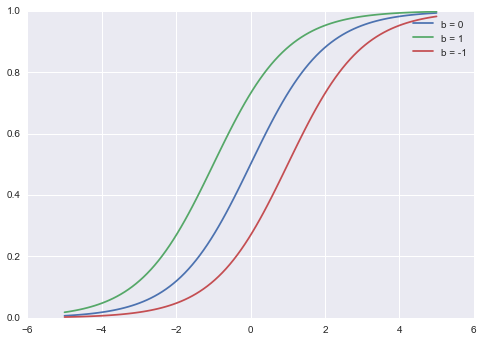

In [1]:
%matplotlib inline
from rasch_model import LearnRaschModel
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns
import time

def logit(c):
    return 1 / (1 + np.exp(-c))

a = np.linspace(-5,5,100)
sns.plt.plot(a, logit(a + 0))
sns.plt.plot(a, logit(a + 1))
sns.plt.plot(a, logit(a - 1))
sns.plt.legend(('b = 0','b = 1','b = -1'));

$$\displaystyle{P(Y_{i,j} = 1) = \frac{1}{1 + \exp(-(a_i + b_j))}}$$

### Question: How can I estimate $a_i$ and $b_j$ given $Y$?

|| Q1 | Q2 | Q3 | Q4 | Q5 | Q6 | Q7|
|-|
| user_1  | 0| 1| | 0| 0| 1| | 
| user_2  | 1| | 1| | 0| | 1| 
| user_3  | | | 0| | 1| | 1| 
| user_4  | 1| | 0| | 0| | 1| 
| user_5  | 0| | 1| | 1| | | 
| user_6  | | 1| 1| | 0| | | 
| user_7  | 0| 0| | 0| | 1| | 
| user_8  | 1| 0| 1| | | 0| | 
| user_9  | 1| 1| | 0| | | 0| 
| user_10 | 0| 0| | | | 1| 1|

$$\displaystyle{P(Y_{i,j} = 1) = \frac{1}{1 + \exp(-(a_i + b_j))}}$$

### Question: How can I estimate $a_i$ and $b_j$ given $Y$?

| user_id | item_id | value |
|-|
| 1 | 1 | 0|
| 1 | 2 | 1|
| 1 | 4 | 0|
| 1 | 5 | 0|
| 1 | 6 | 0|
| 2 | 1 | 1|
| . | . | .|
| . | . | .|
| . | . | .|

       user_id  item_id rating
20366      339     1240   True
20577      343      144   True
69699      846     1540  False
35026      487      685  False
32546      463       25  False


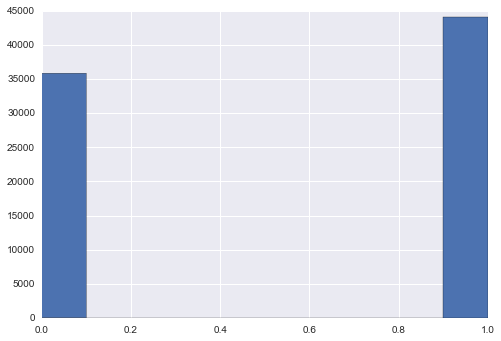

In [2]:
# read data
train = pd.read_csv("data0_train.csv.gz")
test = pd.read_csv("data0_test.csv.gz")

# binarize the response
train['rating'] = train['rating'] > 3
test['rating'] = test['rating'] > 3

# copy data
test_orig = test.copy()

print train.sample(6).head()

# distribution of response
train['rating'].hist();

In [3]:
test = test_orig

# Item Based Popularity
t1 = time.time()
item_pop = train[['item_id', 'rating']]\
            .groupby('item_id')\
            .mean()\
            .reset_index()
item_pop.columns = ['item_id', 'rating_item']
item_mean = np.mean(item_pop['rating_item'])
test = test.merge(item_pop, how='left', on='item_id').fillna(item_mean)
time_item = time.time() - t1

In [4]:
# User Based Popularity
t1 = time.time()

user_pop = train[['user_id', 'rating']]\
            .groupby('user_id')\
            .mean()\
            .reset_index()
user_pop.columns = ['user_id', 'rating_user']
user_mean = np.mean(user_pop['rating_user'])
test = test.merge(user_pop, how='left', on='user_id').fillna(user_mean)
time_user = time.time() - t1

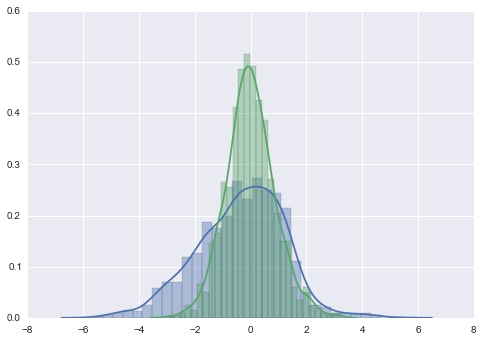

In [5]:
# IRT Based
t1 = time.time()
lrm = LearnRaschModel(max_iter=10, gamma=1.0)
lrm.fit(train, user_id='user_id', item_id='item_id', response='rating')
test['rating_irt'] = lrm.predict(test, user_id='user_id', item_id='item_id')
time_irt = time.time() - t1

sns.distplot(lrm.get_item());
sns.distplot(lrm.get_user());

In [6]:
def get_auc(inp):
    return str(roc_auc_score(test['rating'], test[inp]))

# Evaluate methods
print 'Item Based: ' + get_auc('rating_item'), 'Time: ' + str(time_item)
print 'User Based: ' + get_auc('rating_user'), 'Time: ' + str(time_user)
print 'IRT Based: ' + get_auc('rating_irt'), 'Time: ' + str(time_irt)

Item Based: 0.721633494466 Time: 0.0180869102478
User Based: 0.679446096729 Time: 0.0109870433807
IRT Based: 0.77757235292 Time: 0.487231969833


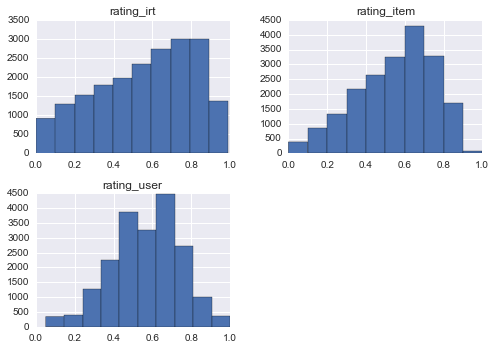

In [7]:
# histogram of the range of values
test[['rating_item', 'rating_user', 'rating_irt']].hist();

$$\displaystyle{P(Y_{i,j} = 1) = \frac{1}{1 + \exp(-(a_i + b_j))}}$$

### Question: How can I estimate $a_i$ and $b_j$ given $Y$?

| user_id | item_id | value |
|-|
| 1 | 1 | 0|
| 1 | 2 | 1|
| 1 | 4 | 0|
| 1 | 5 | 0|
| 1 | 6 | 0|
| 2 | 1 | 1|
| . | . | .|
| . | . | .|
| . | . | .|

## Maximum Likelihood Estimation

- Informally, given data, what is most likely value of the parameters $a$ and $b$
- Example
    - Toss a coin $100$ times, observe $45$ heads and $55$ tails
    - Most likely, probability of heads is $0.45$


- For IRT:
    - Let $p_{i,j} = P(Y_{i,j} = y_{i,j})$
    <br><br>
    - $\displaystyle{\ell = \prod p_{i,j}}$ 
    <br><br>
    - $\displaystyle{\log \ell = \sum \log p_{i,j}}$
    <br><br>
    - Goal: Find $a_i$ and $b_j$ to maximize $\displaystyle{\sum \log p_{i,j}}$

## IRT Parameter Estimation

- $\displaystyle{p_{i,j} = P(Y_{i,j} = y_{i,j}) = \frac{\exp(y_{i,j}(a_i + b_j))}{1 + \exp(a_i + b_j)}}$
<br><br>
- $\displaystyle{ \log p_{i,j} = y_{i,j}(a_i + b_j) - \log(1 + \exp(a_i + b_j)) }$
<br><br>
- Recall, we want to find $a_i$ and $b_j$ that maximizes $\displaystyle{\sum \log p_{i,j}}$
<br><br>
- Final goal:
$$ \max_{a_i, b_j} \sum \left[y_{i,j}(a_i + b_j) - \log(1 + \exp(a_i + b_j)) \right] $$

$$ \max_{a_i, b_j} \sum \left[y_{i,j}(a_i + b_j) - \log(1 + \exp(a_i + b_j)) \right] $$

<br>

| user_id | item_id | y | a | b |
|-|
| 1 | 1 | 0| a_1 | b_1|
| 1 | 2 | 1| a_1 | b_2|
| 1 | 4 | 0| a_1 | b_4|
| 1 | 5 | 0| a_1 | b_5|
| 1 | 6 | 0| a_1 | b_6|
| 2 | 1 | 1| a_2 | b_1|
| . | . | .| | |

## Alternating Maximization
<br>

$$\displaystyle{\max_{a_i, b_j} \sum {\cal L}(a_i, b_j)}$$

- Step 1: Randomly initialize all $a_i$
<br><br>
- Step 2: Solve $\displaystyle{\max_{b_j} \sum {\cal L}(a_i, b_j)}$ to get all the $b_j$
<br><br>
- Step 3: Solve $\displaystyle{\max_{a_j} \sum {\cal L}(a_i, b_j)}$ using $b_j$ from Step 2 to get a new $a_j$
<br><br>
- Repeat Steps 2 and 3 until convergence

## Gradient Descent
<br>

$$ \max_{a_i, b_j} \sum \left[y_{i,j}(a_i + b_j) - \log(1 + \exp(a_i + b_j)) \right] $$

- Let all $a_i = 0$
<br><br>
- $ \max_{b_j} \sum_{i,j} \left[y_{i,j} b_j  - \log(1 + \exp(b_j)) \right] $
<br><br>
- $g_j = \sum_i \left[ y_{i,j} - 1/(1+\exp(-b_j)) \right]$
<br><br>
- $b_j = b_j + \gamma g_j$

In [8]:
train_copy = train.copy()
gamma = 0.001
num_iter = 30
num_items = max(train_copy['item_id'])
b_est = np.random.randn(num_items)
b_init = b_est

def gradient(data):
    """ return gradient """
    grad = train_copy.groupby('item_id')['final_sum'].sum()
    g = np.zeros(num_items)
    g[grad.index - 1] = np.array(grad)
    return g

for k in range(num_iter):
    train_copy['b'] = b_est[train_copy['item_id'] - 1]
    
    # compute y_{ij} - 1 / (1 + exp(-b_j)) for each row
    train_copy['logit'] = 1 / (1 + np.exp(train_copy['b']))
    train_copy['final_sum'] = train_copy['logit'] + train_copy['rating']

    # compute gradient for each item and update b
    b_est = b_est + gamma * gradient(train_copy)

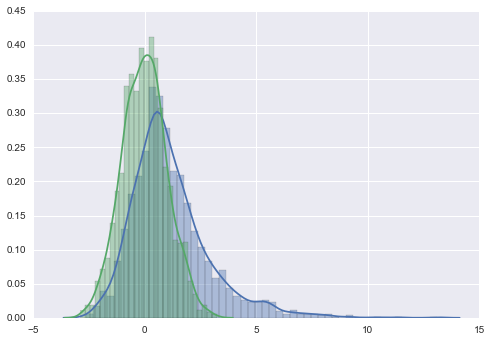

In [9]:
sns.distplot(b_est);
sns.distplot(b_init);

## Computational Complexity

- Iterative Algorithm: O(K)
- Computing Gradient: O(N)


- Simple approach:
```
pandas: grad = train_copy.groupby('item_id')['final_sum']
                           .sum()
```

- Distributed approach:
``` 
pyspark: grad = train_copy.groupby('item_id')
                            .sum('final_sum')
```

- Approximation: Stochastic Gradient Descent (SGD)
```
pandas: grad = train_copy.sample(frac=0.1)
                           .groupby('item_id')['final_sum']
                           .sum()
```
```
pyspark: grad = train_copy.sample(True, 0.1)
                            .groupby('item_id')['final_sum']
                            .sum()
```

- If you know how your data is partitioned, can sample more intelligently


## Summary


- Introduced IRT: Extremely simple variant of Matrix Factorization


- Overview of how to train IRT models and possibly scale them
<br><br>

- Advanced Topics:

    - Many more variants of IRT: see https://en.wikipedia.org/wiki/Item_response_theory
    - Select an appropriate gamma: modify it in every iteration
    - Add more factors, see talks by Spotify (e.g., http://www.slideshare.net/MrChrisJohnson/collaborative-filtering-with-spark)
    - Implicit MF, see http://yifanhu.net/PUB/cf.pdf
    - Use more item and user level data